In [2]:
import pandas as pd
import yaml
import os
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

#import albumentations as A
#from albumentations.pytorch import ToTensorV2

import cv2

from tqdm import tqdm
from PIL import Image

%matplotlib inline

# Split sets exploration

In [56]:
database1_source = ['global-bird-zenodo_poland', 'global-bird-zenodo_palmyra', 'global-bird-zenodo_penguins',
                    'global-bird-zenodo_mckellar', 'global-bird-zenodo_pfeifer', 'uav-waterfowl-thermal',
                    'hayes_albatross', 'terns_africa']

database_folder = r'/gpfs/gibbs/project/jetz/eec42/data/all_datasets_10percent_background'

nb of backgruond img in dataset:  95


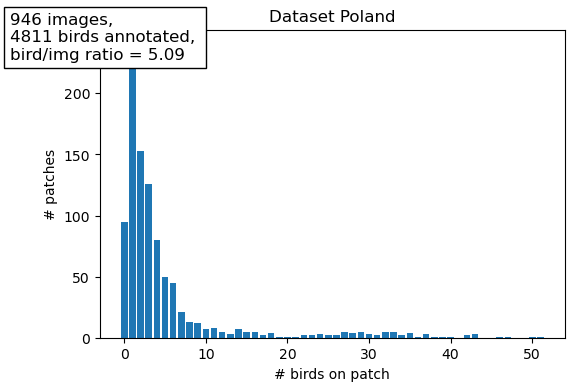

nb of backgruond img in dataset:  175


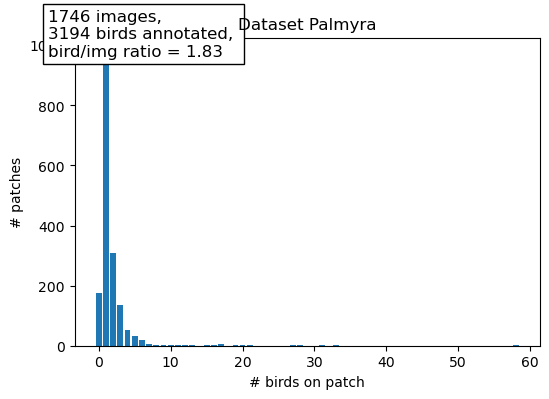

nb of backgruond img in dataset:  78


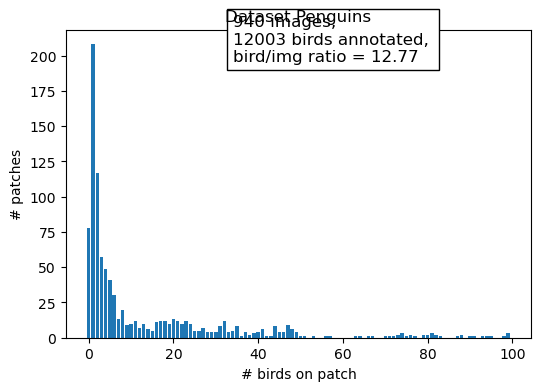

nb of backgruond img in dataset:  98


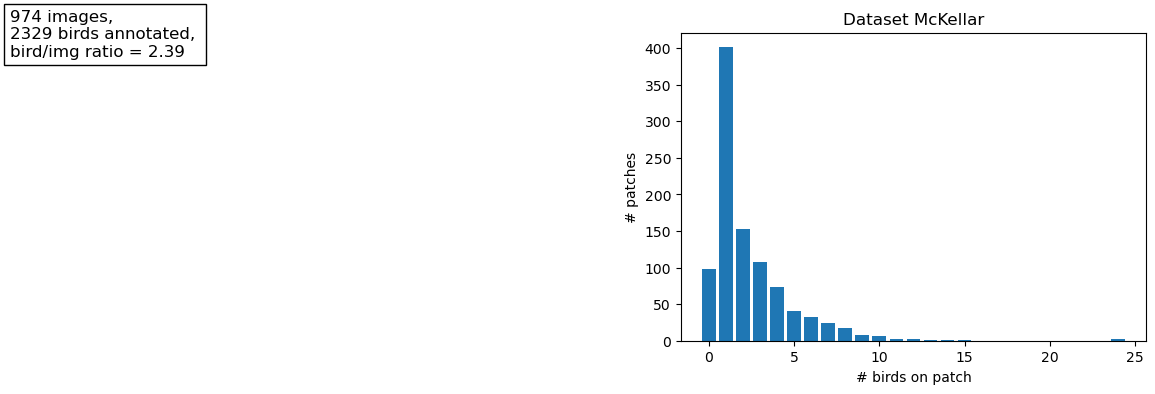

nb of backgruond img in dataset:  335


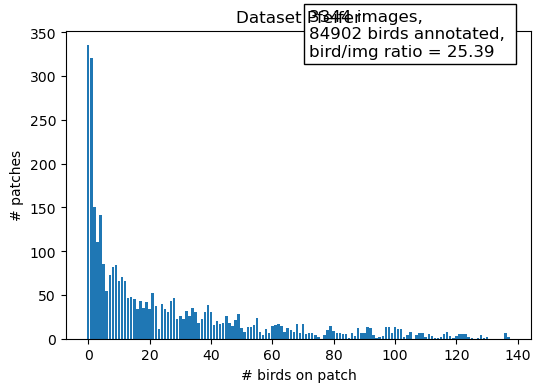

nb of backgruond img in dataset:  78


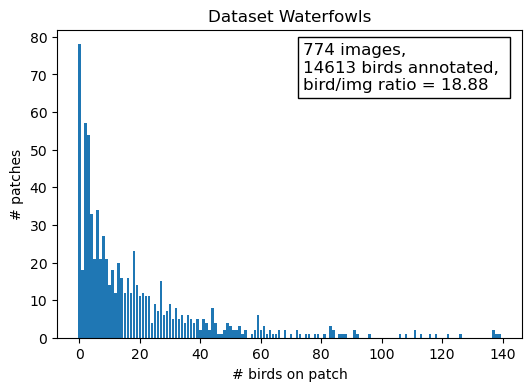

Nb of background images:  859
Total nb of images:  8724


In [60]:
# PER DATASETs
from collections import Counter

with open(os.path.join(database_folder, 'data_stats.yaml'), "r") as yamlfile:
    stats = yaml.load(yamlfile, Loader=yaml.FullLoader)


total_nb_bckgd_img = 0 
total_nb_img = 0 

titles = {'global-bird-zenodo_poland': 'Poland', 
          'global-bird-zenodo_palmyra': 'Palmyra',
          'global-bird-zenodo_penguins': 'Penguins',
          'global-bird-zenodo_mckellar': 'McKellar',
          'global-bird-zenodo_pfeifer': 'Pfeifer',
          'uav-waterfowl-thermal': 'Waterfowls',
          'hayes_albatross': 'Hayes albatross',
          'terns_africa': 'Terns'}

for dataset in database1_source:

    dataset_stats = stats[dataset]

    birds_repartition = z = dict(Counter(dataset_stats['Train']['birds_repartition']) + Counter(dataset_stats['Val']['birds_repartition']) + Counter(dataset_stats['Test']['birds_repartition']))
    nb_birds = dataset_stats['Train']['nb_birds'] + dataset_stats['Val']['nb_birds'] + dataset_stats['Test']['nb_birds']
    nb_img = dataset_stats['Train']['nb_img'] + dataset_stats['Val']['nb_img'] + dataset_stats['Test']['nb_img']
    nb_background_img = nb_img - sum(birds_repartition.values())
    print("nb of backgruond img in dataset: ", nb_background_img)
    total_nb_bckgd_img += nb_background_img
    total_nb_img += nb_img
    birds_repartition[0] = nb_background_img
    bird_img_ratio = nb_birds/nb_img

    plt.figure(figsize=(6,4))
    plt.bar(list(birds_repartition.keys()), birds_repartition.values())#, color='blue')
    plt.title(f'Dataset {titles[dataset]}')
    plt.text(max(birds_repartition.keys())-65, max(birds_repartition.values())-12, f"{nb_img} images, \n{nb_birds} birds annotated, \nbird/img ratio = {str(round(bird_img_ratio, 2))} ", fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
    plt.xlabel('# birds on patch')
    plt.ylabel('# patches')
    plt.show()
    #plt.savefig(os.path.join(exploration_folder, f"stat_{dataset}_split_{split}.png"))

print("Nb of background images: ", total_nb_bckgd_img)
print("Total nb of images: ", total_nb_img)

nb of background img in split:  641


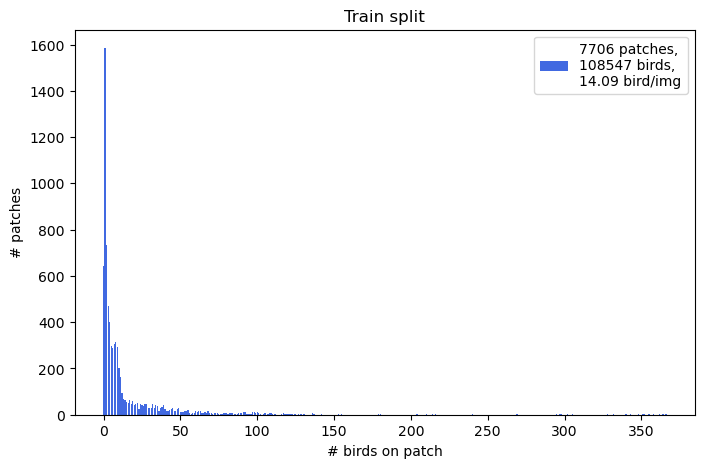

nb of background img in split:  259


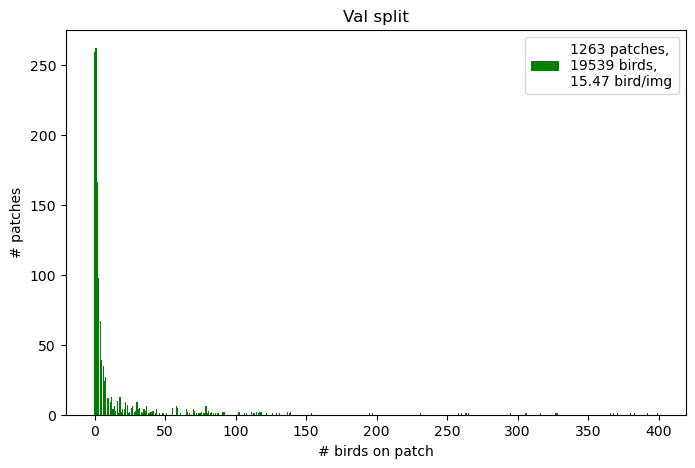

nb of background img in split:  206


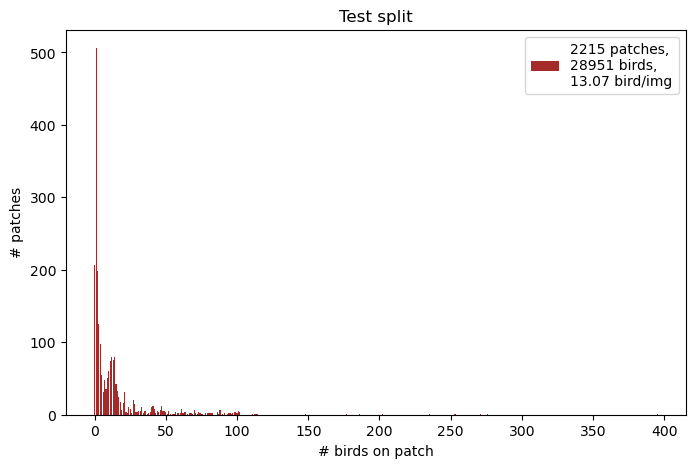

Nb of background images:  1106
Total nb of images:  11184


In [158]:
# PER SPLIT
from collections import Counter
import numpy as np

database1_source = ['global-bird-zenodo_poland', 'global-bird-zenodo_palmyra', 'global-bird-zenodo_penguins',
                    'global-bird-zenodo_mckellar', 'global-bird-zenodo_pfeifer', 'uav-waterfowl-thermal',
                    'hayes_albatross', 'terns_africa']

database_folder = r'/gpfs/gibbs/project/jetz/eec42/data/all_datasets_10percent_background'

with open(os.path.join(database_folder, 'data_stats.yaml'), "r") as yamlfile:
    stats = yaml.load(yamlfile, Loader=yaml.FullLoader)

total_nb_bckgd_img = 0 
total_nb_img = 0 

splits = {'Train': 'royalblue', 'Val': 'green', 'Test': 'brown'}

for split in splits.keys():
    birds_repartition = {}
    nb_birds = 0
    nb_img = 0

    for dataset in database1_source:

        dataset_stats = stats[dataset]
        birds_repartition = dict(Counter(birds_repartition) + Counter(dataset_stats[split]['birds_repartition']))
        nb_birds += dataset_stats[split]['nb_birds']
        nb_img += dataset_stats[split]['nb_img']

    nb_background_img = nb_img - sum(birds_repartition.values())
    print("nb of background img in split: ", nb_background_img)
    total_nb_bckgd_img += nb_background_img
    total_nb_img += nb_img
    birds_repartition[0] = nb_background_img
    bird_img_ratio = nb_birds/nb_img

    birds_repartition = dict(sorted(birds_repartition.items()))
    #print(list(birds_repartition.keys()))
    poly = np.polyfit(list(birds_repartition.keys()),list(birds_repartition.values()),15)
    poly_y = np.poly1d(poly)(list(birds_repartition.keys()))

    plt.figure(figsize=(8,5))
    plt.bar(list(birds_repartition.keys()), birds_repartition.values(), color=splits[split], label=f"{nb_img} patches, \n{nb_birds} birds, \n{str(round(bird_img_ratio, 2))} bird/img")
    #plt.plot(list(birds_repartition.keys()),poly_y, color='orange')
    plt.title(f'{split} split')
    plt.legend()
    #plt.text(max(birds_repartition.keys())-53, max(birds_repartition.values())-80, f"{nb_img} images, \n{nb_birds} birds annotated, \nbird/img ratio = {str(round(bird_img_ratio, 2))} ", fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
    plt.xlabel('# birds on patch')
    plt.ylabel('# patches')
    plt.savefig(os.path.join(database_folder, f"stat_split_{split}.jpg"))
    plt.show()

print("Nb of background images: ", total_nb_bckgd_img)
print("Total nb of images: ", total_nb_img)

nb of background img in split:  68
nb of background img in split:  16
nb of background img in split:  14


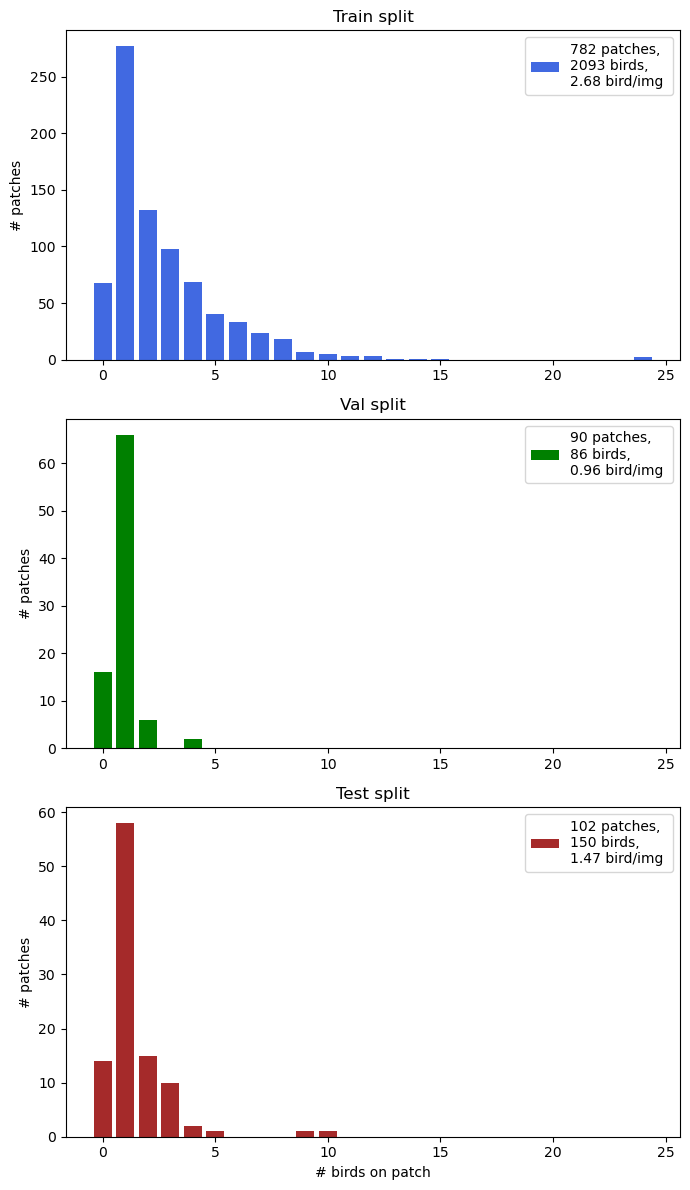

Nb of background images:  98
Total nb of images:  974


In [162]:
# PER SPLITS & DATASETS
from collections import Counter

database1_source = ['global-bird-zenodo_mckellar']

database_folder = r'/gpfs/gibbs/project/jetz/eec42/data/all_datasets_10percent_background'
exploration_folder = r'/gpfs/gibbs/project/jetz/eec42/data/visualization'

splits = {'Train': 'royalblue', 'Val': 'green', 'Test': 'brown'}

with open(os.path.join(database_folder, 'data_stats.yaml'), "r") as yamlfile:
    stats = yaml.load(yamlfile, Loader=yaml.FullLoader)
    
total_nb_bckgd_img = 0 
total_nb_img = 0 

for dataset in database1_source:

    dataset_stats = stats[dataset]
    fig, ax = plt.subplots(3, 1, figsize=(7, 12), sharex=True, tight_layout=True)
    
    for i, split in enumerate(['Train', 'Val', 'Test']):
        birds_repartition = dataset_stats[split]['birds_repartition']
        nb_birds = dataset_stats[split]['nb_birds']
        nb_img = dataset_stats[split]['nb_img']
        nb_background_img = nb_img - sum(birds_repartition.values())
        print("nb of background img in split: ", nb_background_img)
        total_nb_bckgd_img += nb_background_img
        total_nb_img += nb_img
        birds_repartition[0] = nb_background_img
        bird_img_ratio = nb_birds/nb_img

        ax[i].bar(list(birds_repartition.keys()), birds_repartition.values(), color=splits[split], label=f"{nb_img} patches, \n{nb_birds} birds, \n{str(round(bird_img_ratio, 2))} bird/img ")
        ax[i].legend()
        #ax[i].bar_label(ax[i].containers[0], fmt="{:0.2f}")
        #ax[i].title(f'Dataset {dataset}, {split} subset')
        #ax[i].text(25-10, 260-100, f"{split} split:\n{nb_img} images, \n{nb_birds} birds, \n{str(round(bird_img_ratio, 2))} bird/img ", fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
        #ax[i].set_xlabel('Nb of birds on patch')
        ax[i].set_ylabel('# patches')
        ax[i].set_title(f'{split} split')
        #plt.setp(ax[i].get_xticklabels(), visible=True) 
        ax[i].tick_params(labelbottom=True)
        #ax[i].set_yticks([0,200])

    ax[2].set_xlabel('# birds on patch')
    #plt.setp(ax[0].get_xticklabels(), visible=True) 
    fname = os.path.join(exploration_folder, f"stat_{dataset}_all_splits.jpg")
        #if not (dataset=='global-bird-zenodo_penguins' and (split=='Train' or split=='Val')):
    plt.savefig(fname, dpi=200)
    plt.show()

print("Nb of background images: ", total_nb_bckgd_img)
print("Total nb of images: ", total_nb_img)

In [14]:
database_folder = r'/gpfs/gibbs/project/jetz/eec42/data/original/global_birds_palmyra/palmyra_train.csv'

data = pd.read_csv(database_folder)
data.groupby(['image_path']).count().sort_values(by=["xmin"], ascending=False) #['xmin'].argmax()


,xmin,ymin,xmax,ymax,label
image_path,,,,,
CooperStrawn_53m_tile_clip_projected_915.png,68,68,68,68,68
CooperStrawn_53m_tile_clip_projected_848.png,41,41,41,41,41
CooperStrawn_53m_tile_clip_projected_538.png,36,36,36,36,36
CooperStrawn_53m_tile_clip_projected_884.png,31,31,31,31,31
CooperStrawn_53m_tile_clip_projected_916.png,30,30,30,30,30
...,...,...,...,...,...
CooperStrawn_53m_tile_clip_projected_717.png,1,1,1,1,1
CooperStrawn_53m_tile_clip_projected_718.png,1,1,1,1,1
CooperStrawn_53m_tile_clip_projected_720.png,1,1,1,1,1


## **Datasets means & standard deviations computation**

In [10]:
from PIL import Image
import numpy as np

dataset_path = '/gpfs/gibbs/project/jetz/eec42/data/formatted_data_10percent_background_/'

splits =  ['uav_thermal_waterfowl']
'''['global_birds_poland', 'global_birds_palmyra', 'global_birds_penguins',
                    'global_birds_mckellar', 'global_birds_newmexico', 
                    'global_birds_pfeifer', 'hayes_albatross', 'terns_africa', 'uav_thermal_waterfowl',]
                '''


for split in splits:
    # dataset
    split_path = os.path.join('/gpfs/gibbs/project/jetz/eec42/data/formatted_data_10percent_background_/' + split + '/images')
    available_img = os.listdir(split_path)

    mean_channel1 = 0
    mean_channel2 = 0
    mean_channel3 = 0
    std_channel1 = 0
    std_channel2 = 0
    std_channel3 = 0

    for img_name in available_img:
        img = np.asarray(Image.open(os.path.join(split_path,img_name)))
        #print(np.shape(img))
        mean_channel1 += img[:,:].mean()
        #mean_channel1 += img[:,:,0].mean()
        #mean_channel2 += img[:,:,1].mean()
        #mean_channel3 += img[:,:,2].mean()
        std_channel1 += img[:,:].std()
        #std_channel1 += img[:,:,0].std()
        #std_channel2 += img[:,:,1].std()
        #std_channel3 += img[:,:,2].std()
    
    mean_channel1 = mean_channel1/len(available_img)
    #mean_channel2 = mean_channel2/len(available_img)
    #mean_channel3 = mean_channel3/len(available_img)

    std_channel1 = std_channel1/len(available_img)
    #std_channel2 = std_channel2/len(available_img)
    #std_channel3 = std_channel3/len(available_img)

    print('SPLIT: ', split)
    #print(f'mean: {mean_channel1, mean_channel2, mean_channel3} ')
    #print(f'std: {std_channel1, std_channel2, std_channel3}')
    print(f'mean: {mean_channel1} ')
    print(f'std: {std_channel1}')


SPLIT:  uav_thermal_waterfowl
mean: 106.19987357186409 
std: 27.35747560056434


In [19]:
img = np.asarray(Image.open(os.path.join(split_path,available_img[0])))
np.max(img)

255

In [2]:
##### PARAMS
#device      = torch.device('cpu') 
num_workers = 4
batch_size  = 128
image_size  = 224


##### DATASET

class ImageData(Dataset):
    
    def __init__(self, img_list, directory):
        super().__init__()
        self.img_list  = img_list
        self.directory = directory
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        
        # import
        path  = os.path.join(self.directory, self.img_list[idx])
        image = cv2.imread(path, cv2.COLOR_BGR2RGB)

        if image is None:
            raise FileNotFoundError(self.directory)
            
        return image

In [7]:
#splits = ['train','val','test']
splits =  ['global_birds_poland', 'global_birds_palmyra', 'global_birds_penguins',
                    'global_birds_mckellar', 'global_birds_newmexico', 
                    'global_birds_pfeifer', 'uav_thermal_waterfowl', 'hayes_albastross', 'terns_africa']


for split in splits:
    # dataset
    dataset_path = '/gpfs/gibbs/project/jetz/eec42/data/formatted_data_10percent_background_'
    split_path = os.path.join('/gpfs/gibbs/project/jetz/eec42/data/formatted_data_10percent_background_/' + split + '/images')
    available_img = os.listdir(split_path)
    image_dataset = ImageData(img_list      = available_img,
                              directory     = split_path)

    # data loader
    image_loader = DataLoader(image_dataset, 
                            batch_size  = 128, #len(available_img), 
                            shuffle     = False, 
                            num_workers = num_workers,
                            pin_memory  = True)


    image_size = Image.open(os.path.join(split_path, available_img[0])).size[0]
    im = Image.open(os.path.join(split_path, available_img[0]))
    print(im)

    ####### COMPUTE MEAN / STD

    # placeholders
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    # loop through images
    for inputs in tqdm(image_loader):
        #print(inputs[0])
        psum    += inputs.sum(axis        = [0, 1, 2]) / (image_size * image_size)
        psum_sq += (inputs ** 2).sum(axis = [0, 1, 2]) / (image_size * image_size)


    ####### FINAL CALCULATIONS

    # pixel count
    count = len(available_img) #* image_size * image_size

    # mean and std
    total_mean = psum / count
    #print(psum_sq)
    #print(count)
    #print(psum_sq/count)
    #print(total_mean ** 2)
    #print((psum_sq / count) - (total_mean ** 2))
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(torch.abs(total_var))

    # output
    print('SPLIT: ', split)
    print('mean: '  + str(total_mean.mean()))
    print('std:  '  + str(total_std.mean()))

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x1537E9582010>


 25%|██▌       | 2/8 [00:04<00:14,  2.38s/it]


KeyboardInterrupt: 

In [7]:
####### COMPUTE MEAN / STD

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum    += inputs.sum(axis        = [0, 1, 2])
    psum_sq += (inputs ** 2).sum(axis = [0, 1, 2])


####### FINAL CALCULATIONS

# pixel count
count = len(available_img) * image_size * image_size

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

100%|██████████| 7/7 [00:01<00:00,  4.29it/s]

mean: tensor([106.1132, 106.1132, 106.1132])
std:  tensor([nan, nan, nan])


## **Visualization**

In [16]:
from preprocessing_utils import preview_few_images, extract_dataset_config, load_config

database1_source = ['hayes_albatross']
'''['global-bird-zenodo_poland', 'global-bird-zenodo_palmyra', 'global-bird-zenodo_penguins',
                    'global-bird-zenodo_mckellar', 'global-bird-zenodo_newmexico', 
                    'global-bird-zenodo_pfeifer', 'uav-waterfowl-thermal']'''

database_folder = r'/gpfs/gibbs/project/jetz/eec42/data/formatted_data_'
saving_path = r'/gpfs/gibbs/project/jetz/eec42/data/visualization'

In [17]:
YAML_PATH = r'/home/eec42/BirdDetector/src/data_preprocessing/source_datasets_config.yaml'
config = load_config(YAML_PATH)
category_name_to_id = {'bird': 0}

for dataset in database1_source:
    # Extract specific dataset config
    dataset_config = extract_dataset_config(config, dataset)
    dataset_folder = os.path.join(database_folder, dataset_config["name"])
    os.makedirs(os.path.join(saving_path, dataset_config["name"]))

    preview_few_images(dataset_config, dataset_folder, category_name_to_id, nb_display=10, saving_path=os.path.join(saving_path, dataset_config["name"]) + '/')
    

Datasets config read successful


## **Find mean size of bboxes per dataset**

In [24]:
from preprocessing_utils import preview_few_images, extract_dataset_config, load_config, preview_image
import glob 
from pathlib import Path
import math

database1_source = ['global-bird-zenodo_poland', 'global-bird-zenodo_palmyra', 'global-bird-zenodo_penguins',
                    'global-bird-zenodo_mckellar', 'global-bird-zenodo_newmexico', 
                    'global-bird-zenodo_pfeifer', 'uav-waterfowl-thermal', 'hayes_albatross', 'terns_africa'] 

database_folder = r'/gpfs/gibbs/project/jetz/eec42/data/formatted_data_'

In [26]:
YAML_PATH = r'/home/eec42/BirdDetector/src/data_preprocessing/source_datasets_config.yaml'
config = load_config(YAML_PATH)
category_name_to_id = {'bird': 0}

for dataset in database1_source:

    sum_bbox_size = 0
    nb_bbox = 0

    # Extract specific dataset config
    dataset_config = extract_dataset_config(config, dataset)
    dataset_folder = os.path.join(database_folder, dataset_config["name"])

    to_search = '/labels/**/*' + '.txt' #dataset_config["image_extension"]
    available_images = glob.glob(dataset_folder + to_search, recursive=True)

    img_size = int(Path(available_images[100]).stem[-3:])

    for label in available_images:
        df = pd.read_csv(label, sep='\t', header=None, index_col=False)
        for irow, row in df.iterrows():  
            nb_bbox += 1
            sum_bbox_size += row[3]*row[4]*img_size*img_size
    
    mean_bbox_size = sum_bbox_size/nb_bbox
    print("Dataset: ", dataset)
    print("Mean bbox size: ", math.sqrt(mean_bbox_size))
    print("0.7 of bbox size:", mean_bbox_size*0.7)
    print("0.5 of bbox size:", mean_bbox_size*0.5)


Datasets config read successful
Dataset:  hayes_albatross
Mean bbox size:  67.84463980290545
0.7 of bbox size: 3222.0266049901875
0.5 of bbox size: 2301.447574992991
Dataset:  terns_africa
Mean bbox size:  39.7748367720005
0.7 of bbox size: 1107.426348167498
0.5 of bbox size: 791.0188201196414


## **Nb of background patch in formatted_Data**

In [11]:
DATA_FOLDER = r'/gpfs/gibbs/project/jetz/eec42/data/formatted_data_'
DATASETS = ['global_birds_palmyra', 'global_birds_pfeifer',
            'global_birds_mckellar', 'global_birds_penguins', 
            'global_birds_poland', 'uav_thermal_waterfowl']

In [12]:
for dataset in DATASETS:
    DATASET_FOLDER = os.path.join(DATA_FOLDER, dataset)
    IMG_FOLDER = os.path.join(DATASET_FOLDER, "images")
    LABEL_FOLDER = os.path.join(DATASET_FOLDER, "labels")

    label_list = os.listdir(LABEL_FOLDER)
    img_list = os.listdir(IMG_FOLDER)

    print(f"Dataset {dataset}: {len(img_list) - len(label_list)} background images")


Dataset global_birds_palmyra: 2497 background images
Dataset global_birds_pfeifer: 375 background images
Dataset global_birds_mckellar: 740 background images
Dataset global_birds_penguins: 78 background images
Dataset global_birds_poland: 673 background images
Dataset uav_thermal_waterfowl: 388 background images
